# Visualise Attention Geometry

In [33]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import torch
from torch_geometric.data import Data, DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, knn_graph, radius_graph
from torch.nn import functional as F
import scipy as sp
import wandb

import warnings
 
warnings.filterwarnings("ignore")
sys.path.append("../../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from models.submodels.agnn import GraphLevelAGNN
from models.submodels.gravnet import GravNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Roadmap

- Get output of spatial network
- Get size of final node features
- Apply model to some events
- Visualise spatial network distances vs. true/false tracks
- Visualise size of final node features vs. true/false tracks

In [2]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/LRP_Study_E/25rte0wc/checkpoints/epoch=94-step=9499.ckpt" # This is the Vanilla GravNet model
# checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/LRP_Study_E/23vn5x0s/checkpoints/epoch=180-step=18099.ckpt" # This is the Level-0 GravNet model
# checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/LRP_Study_E/1bqa4di1/checkpoints/epoch=194-step=19499.ckpt" # This is the Level-0 GravNet model
model = GravNet.load_from_checkpoint(checkpoint_path).to(device)

In [3]:
model.hparams["datatype_split"] = [100, 100, 10]

## Test Dataloading

In [5]:
model.setup(stage="fit")

Setting up dataset


100%|██████████| 10/10 [00:00<00:00, 196.50it/s]


In [6]:
sample = model.trainset[0]

In [7]:
sample

Data(x=[96, 2], edge_index=[2, 914], y=[914], modulewise_true_edges=[85, 2], signal_true_edges=[85, 2], pt=[96], pid=[96], y_pid=[914], pid_signal=[914], y_trigger=False)

In [6]:
for batch in model.train_dataloader():
    sample = batch.to(device)
    break

In [8]:
with torch.no_grad():
    model.eval()
    output, attention_log = model(sample.x, sample.edge_index, sample.batch, log_attention=True)

<AxesSubplot:ylabel='Density'>

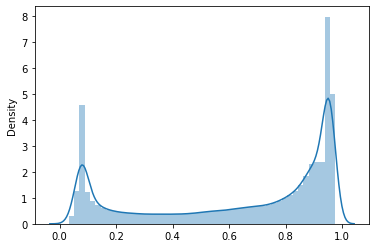

In [17]:
sns.distplot(torch.stack(attention_log).max(dim=0)[0].cpu().numpy())

<AxesSubplot:ylabel='Density'>

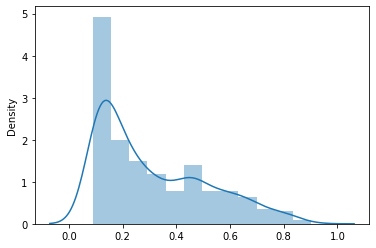

In [33]:
sns.distplot(sample.max_attention.cpu().numpy())

In [20]:
attention_cut = 0.9
stacked_attention = torch.stack(attention_log).max(dim=0)[0]

print(f"Number of edges passing cut: {stacked_attention[stacked_attention > attention_cut].shape[0]}, meaning {stacked_attention[stacked_attention > attention_cut].shape[0]/sample.x.shape[0]} edges per node")

Number of edges passing cut: 258664, meaning 28.31260945709282 edges per node


In [ ]:
top_dir = "/global/cfs/cdirs/m3443/data/TrackLRP/attention_cut_dir_1"
with torch.no_grad():
    model.eval()
    for dataset, dataname in zip([model.trainset, model.valset, model.testset], ["train", "val", "test"]):
        dataloader = DataLoader(dataset, batch_size=1, num_workers=0)
        save_dir = os.path.join(top_dir, dataname)
        os.makedirs(save_dir, exist_ok=True)
        for i, batch in enumerate(tqdm(dataloader)):
            sample = batch.to(device)
            output, attention_log = model(sample.x, sample.edge_index, sample.batch, log_attention=True)
            stacked_attention = torch.stack(attention_log).max(dim=0)[0]
            sample.max_attention = stacked_attention
            torch.save(sample.cpu(), os.path.join(save_dir, f"{i}.pt"))

100%|██████████| 1000/1000 [00:37<00:00, 26.60it/s]


In [ ]:
test_sample = torch.load(os.path.join(save_dir, "1.pt"))

In [ ]:
test_sample

DataBatch(x=[84, 2], edge_index=[2, 6463], y=[6463], modulewise_true_edges=[73, 2], signal_true_edges=[73, 2], pt=[84], pid=[84], y_pid=[6463], pid_signal=[6463], y_trigger=[1], batch=[84], ptr=[2], max_attention=[6463, 1])

In [41]:
test_sample.edge_index[:, test_sample.max_attention.squeeze() > 0.9].shape

torch.Size([2, 1470])

<AxesSubplot:ylabel='Count'>

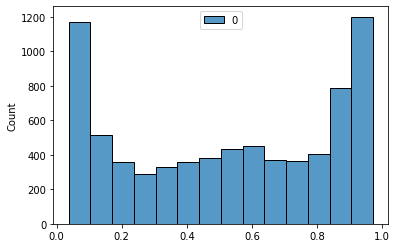

In [29]:
sns.histplot(test_sample.max_attention.numpy())

## Apply Model

In [4]:
model.setup(stage="fit")

Setting up dataset


100%|██████████| 10/10 [00:00<00:00, 250.63it/s]


In [5]:
sample = model.trainset[0]

In [6]:
sample

Data(x=[99, 2], edge_index=[2, 930], y=[930], modulewise_true_edges=[88, 2], signal_true_edges=[88, 2], pt=[99], pid=[99], y_pid=[930], pid_signal=[930], y_trigger=True)

In [9]:
loader = DataLoader(model.valset, batch_size=1, num_workers=0, shuffle=True)
for batch in loader:
    sample = batch.to(device)
    break

In [10]:
sample.x.shape, sample.y_trigger

(torch.Size([87, 2]), tensor([True], device='cuda:0'))

In [11]:
with torch.no_grad():
    model.eval()
    output, edge_log, spatial_log, hidden_log = model(sample.x, sample.edge_index, sample.batch, log_attention=True)

## Visualise Attention Geometry

### Vanilla GravNet

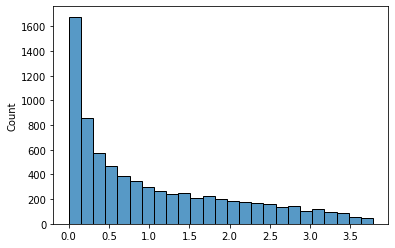

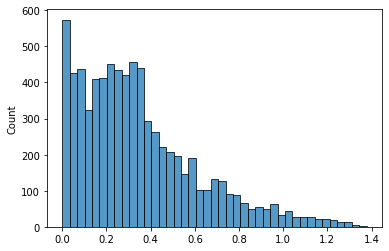

In [12]:
for spatial in spatial_log:
    # knn_edges = knn_graph(spatial, 10, batch=sample.batch)
    knn_edges = radius_graph(spatial, 2.0, batch=sample.batch, max_num_neighbors=1000)
    d = torch.sum((spatial[knn_edges[0]] - spatial[knn_edges[1]])**2, dim=1).cpu()
    sns.histplot(d)
    plt.pause(1)

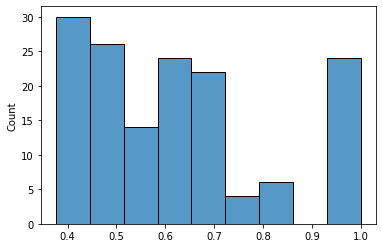

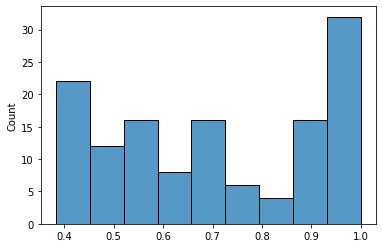

In [15]:
for spatial in spatial_log:
    # knn_edges = knn_graph(spatial, 10, batch=sample.batch)
    knn_edges = radius_graph(spatial, 0.1, batch=sample.batch, max_num_neighbors=1000)
    d = torch.sum((spatial[knn_edges[0]] - spatial[knn_edges[1]])**2, dim=1).cpu()
    att = torch.exp(-100*d)
    sns.histplot(att)
    plt.pause(1)

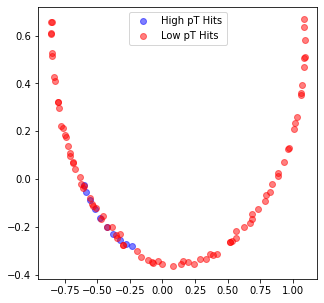

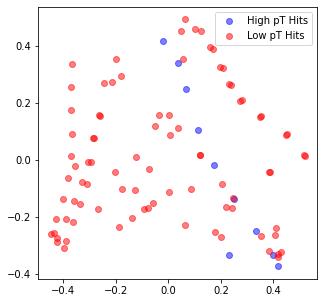

In [12]:
# Apply 2D PCA to spatial_log
from sklearn.decomposition import PCA

for spatial in spatial_log:
    pca = PCA(n_components=2)
    spatial_pca = pca.fit_transform(spatial.cpu().numpy())

    # Plot the PCA
    plt.figure(figsize=(5, 5))
    high_pt_hits = (sample.pt >= 800.0).cpu()
    plt.scatter(spatial_pca[high_pt_hits, 0], spatial_pca[high_pt_hits, 1], label="High pT Hits", alpha=0.5, c="blue")
    plt.scatter(spatial_pca[~high_pt_hits, 0], spatial_pca[~high_pt_hits, 1], label="Low pT Hits", alpha=0.5, c="red")
    plt.legend()
    plt.show()
    plt.pause(1)

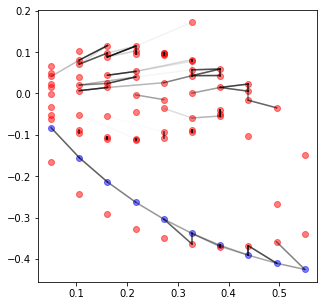

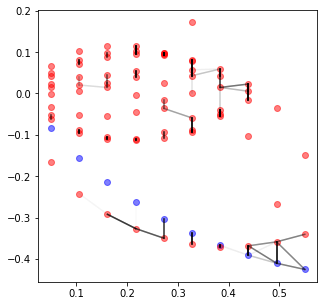

In [25]:
# Plot sample x with knn_edges as edges weighted by distance
for spatial in spatial_log:
    high_pt_hits = (sample.pt >= 800.0).cpu()
    # knn_edges = knn_graph(spatial, 10, batch=sample.batch)
    knn_edges = radius_graph(spatial, 0.1, batch=sample.batch, max_num_neighbors=1000)
    d = torch.sum((spatial[knn_edges[0]] - spatial[knn_edges[1]])**2, dim=1).cpu()
    atts = torch.exp(-100*d)
    atts = (atts - atts.min()) / (atts.max() - atts.min())
    plt.figure(figsize=(5, 5))
    for edge, att in zip(knn_edges.cpu().numpy().T, atts.numpy()):
        plt.plot(sample.x[edge, 0].cpu(), sample.x[edge, 1].cpu(), c="black", alpha=att)
    plt.scatter(sample.x[high_pt_hits, 0].cpu(), sample.x[high_pt_hits, 1].cpu(), label="High pT Hits", alpha=0.5, c="blue")
    plt.scatter(sample.x[~high_pt_hits, 0].cpu(), sample.x[~high_pt_hits, 1].cpu(), label="Low pT Hits", alpha=0.5, c="red")

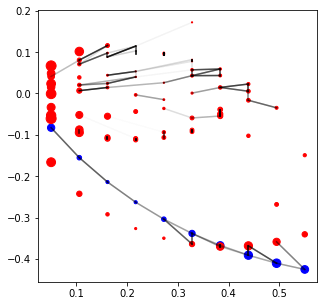

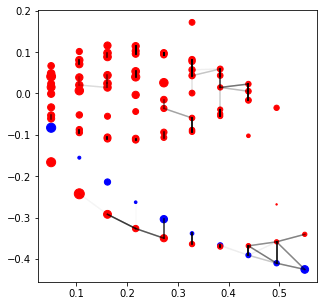

In [30]:
# Plot sample x with knn_edges as edges weighted by distance
for spatial, hidden in zip(spatial_log, hidden_log):
    hidden = hidden.sum(dim=1).cpu().abs() ## IS THIS RIGHT??
    # hidden = hidden.abs().sum(dim=1).cpu() ## IS THIS RIGHT??
    hidden = (hidden - hidden.min()) / (hidden.max() - hidden.min())
    high_pt_hits = (sample.pt >= 800.0).cpu()
    # knn_edges = knn_graph(spatial, 10, batch=sample.batch)
    knn_edges = radius_graph(spatial, 0.1, batch=sample.batch)
    d = torch.sum((spatial[knn_edges[0]] - spatial[knn_edges[1]])**2, dim=1).cpu()
    atts = torch.exp(-100*d)
    atts = (atts - atts.min()) / (atts.max() - atts.min())
    plt.figure(figsize=(5, 5))
    for edge, att in zip(knn_edges.cpu().numpy().T, atts.numpy()):
        plt.plot(sample.x[edge, 0].cpu(), sample.x[edge, 1].cpu(), c="black", alpha=att)
    plt.scatter(sample.x[high_pt_hits, 0].cpu(), sample.x[high_pt_hits, 1].cpu(), label="High pT Hits", s=100*hidden[high_pt_hits]**2, c="blue")
    plt.scatter(sample.x[~high_pt_hits, 0].cpu(), sample.x[~high_pt_hits, 1].cpu(), label="Low pT Hits", s=100*hidden[~high_pt_hits]**2, c="red")

### Massless GravNet

In [103]:
spatial_log[0].shape

torch.Size([84, 16])

In [104]:
knn_edges = knn_graph(spatial_log[0], 10, batch=sample.batch)
d = torch.sum((spatial_log[0][knn_edges[0]] - spatial_log[0][knn_edges[1]])**2, dim=1).cpu().sqrt()

In [105]:
sample

DataBatch(x=[84, 2], edge_index=[2, 767], y=[767], modulewise_true_edges=[73, 2], signal_true_edges=[73, 2], pt=[84], pid=[84], y_pid=[767], pid_signal=[767], y_trigger=[1], batch=[84], ptr=[2])

<AxesSubplot:ylabel='Count'>

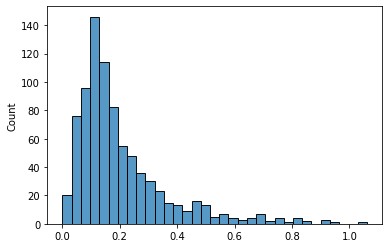

In [106]:
sns.histplot(d)

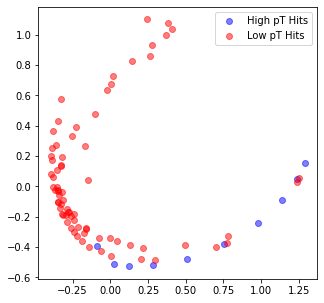

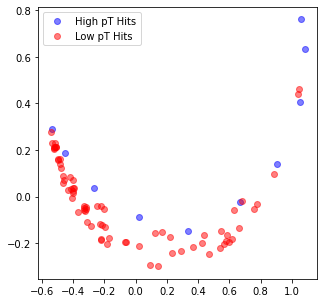

In [107]:
# Apply 2D PCA to spatial_log
from sklearn.decomposition import PCA

for spatial in spatial_log:
    pca = PCA(n_components=2)
    spatial_pca = pca.fit_transform(spatial.cpu().numpy())

    # Plot the PCA
    plt.figure(figsize=(5, 5))
    high_pt_hits = (sample.pt >= 800.0).cpu()
    plt.scatter(spatial_pca[high_pt_hits, 0], spatial_pca[high_pt_hits, 1], label="High pT Hits", alpha=0.5, c="blue")
    plt.scatter(spatial_pca[~high_pt_hits, 0], spatial_pca[~high_pt_hits, 1], label="Low pT Hits", alpha=0.5, c="red")
    plt.legend()
    plt.show()
    plt.pause(1)

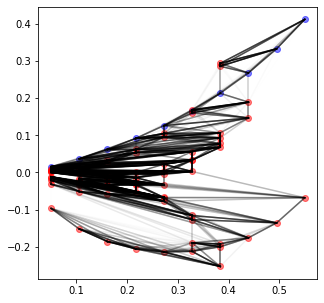

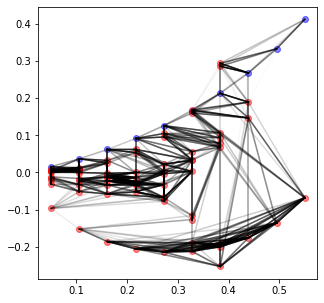

In [108]:
# Plot sample x with knn_edges as edges weighted by distance
for spatial in spatial_log:
    high_pt_hits = (sample.pt >= 800.0).cpu()
    knn_edges = knn_graph(spatial, 10, batch=sample.batch)
    d = torch.sum((spatial[knn_edges[0]] - spatial[knn_edges[1]])**2, dim=1).cpu().sqrt()
    d = (d - d.min()) / (d.max() - d.min())
    plt.figure(figsize=(5, 5))
    plt.scatter(sample.x[high_pt_hits, 0].cpu(), sample.x[high_pt_hits, 1].cpu(), label="High pT Hits", alpha=0.5, c="blue")
    plt.scatter(sample.x[~high_pt_hits, 0].cpu(), sample.x[~high_pt_hits, 1].cpu(), label="Low pT Hits", alpha=0.5, c="red")
    for edge, distance in zip(knn_edges.cpu().numpy().T, d.numpy()):
        plt.plot(sample.x[edge, 0].cpu(), sample.x[edge, 1].cpu(), c="black", alpha=(1-distance)**4)

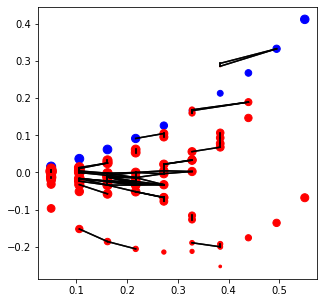

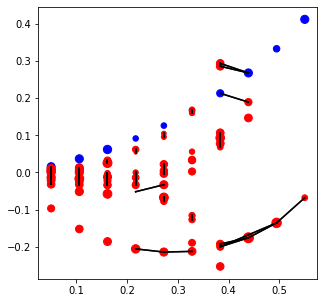

In [114]:
# Plot sample x with knn_edges as edges weighted by distance
for spatial, hidden in zip(spatial_log, hidden_log):
    hidden = hidden.sum(dim=1).cpu().abs()
    hidden = (hidden - hidden.min()) / (hidden.max() - hidden.min())
    high_pt_hits = (sample.pt >= 800.0).cpu()
    # knn_edges = knn_graph(spatial, 10, batch=sample.batch)
    knn_edges = radius_graph(spatial, 0.1, batch=sample.batch)
    d = torch.sum((spatial[knn_edges[0]] - spatial[knn_edges[1]])**2, dim=1).cpu().sqrt()
    # d = (d - d.min()) / (d.max() - d.min())
    plt.figure(figsize=(5, 5))
    for edge, distance in zip(knn_edges.cpu().numpy().T, d.numpy()):
        plt.plot(sample.x[edge, 0].cpu(), sample.x[edge, 1].cpu(), c="black", alpha=(1-distance))
    # plt.scatter(sample.x[high_pt_hits, 0].cpu(), sample.x[high_pt_hits, 1].cpu(), label="High pT Hits", alpha=hidden[high_pt_hits]**4, c="blue")
    # plt.scatter(sample.x[~high_pt_hits, 0].cpu(), sample.x[~high_pt_hits, 1].cpu(), label="Low pT Hits", alpha=hidden[~high_pt_hits]**4, c="red")
    plt.scatter(sample.x[high_pt_hits, 0].cpu(), sample.x[high_pt_hits, 1].cpu(), label="High pT Hits", s=100*hidden[high_pt_hits], c="blue")
    plt.scatter(sample.x[~high_pt_hits, 0].cpu(), sample.x[~high_pt_hits, 1].cpu(), label="Low pT Hits", s=100*hidden[~high_pt_hits], c="red")